In [1]:
from tools.utils import *
from tools.hom_networks import *

import torch

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Random
seed = 42

# Model
hidden_channels = 128
num_classes = 6
# num_layers = 2 # varying
aggr='mean'
dropout = 0.5
# use_skip_connections = True # varying

# Training
batch_size = 32
epochs = 30
decay = 1e-4
lr = 1e-4
maxlr = 3e-4

# Preprocess

In [3]:
# Load the ENZYMES dataset
hom_dataset = TUDataset(root='data', name='ENZYMES')                          # This has 3 one-hot encodings
hom_dataset_attr = TUDataset(root='data', name='ENZYMES', use_node_attr=True) # This has 3 one-hot encodings and 18 features

In [4]:
def normalize_enzymes_data(data):
    data = data.clone()
    if hasattr(data, 'x') and data.x is not None:
        x = data.x
        feats = x[:, :18]
        mean = feats.mean(dim=0)
        std = feats.std(dim=0, unbiased=False)
        std[std == 0] = 1.0
        normalized_feats = (feats - mean) / std
        x[:, :18] = normalized_feats
        data.x = x
    return data

# Normalize features
normalized_hom_dataset_attr = [normalize_enzymes_data(hom_data) for hom_data in hom_dataset_attr]

In [5]:
# Create splits
labels = [data.y.item() for data in normalized_hom_dataset_attr]

train_set, temp_set = train_test_split(
    normalized_hom_dataset_attr, 
    test_size=0.3, 
    stratify=labels,
    random_state=seed
    
)

temp_labels = [data.y.item() for data in temp_set]
valid_set, test_set = train_test_split(
    temp_set, 
    test_size=0.5, 
    stratify=temp_labels,
    random_state=seed
)

# train_loader is defined at each experiment for reproducibility
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# 1 layer, no skip, GraphConv

Epoch 1/30
Train Loss: 1.7930 | Validation Loss: 1.7925
Train Acc: 0.1643 | Validation Acc: 0.1667
Train F1: 0.0470 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.7925 | Validation Loss: 1.7924
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.7924 | Validation Loss: 1.7923
Train Acc: 0.1643 | Validation Acc: 0.1667
Train F1: 0.0470 | Validation F1: 0.0476

Epoch 4/30
Train Loss: 1.7920 | Validation Loss: 1.7921
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.7920 | Validation Loss: 1.7918
Train Acc: 0.1571 | Validation Acc: 0.1667
Train F1: 0.0562 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.7913 | Validation Loss: 1.7917
Train Acc: 0.1762 | Validation Acc: 0.1667
Train F1: 0.0682 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7918 | Validation Loss: 1.7914
Train Acc: 0.1595 | Validation Acc: 0.1667
Train F1: 0.0675 | Validation F1: 0.0476

Epoch 8/30
Tr

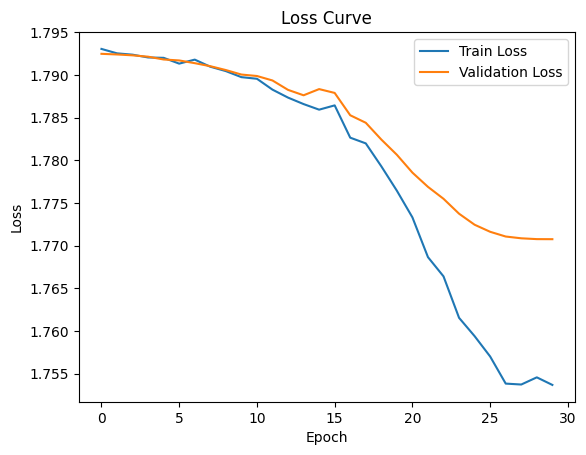

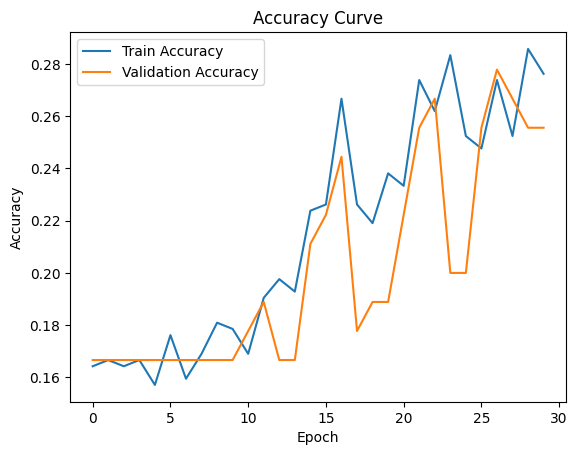

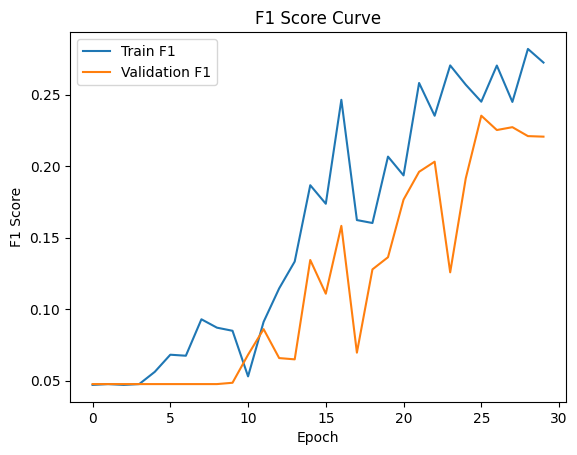

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7930,1.7925,0.1643,0.1667,0.0470,0.0476
1,2,1.7925,1.7924,0.1667,0.1667,0.0476,0.0476
2,3,1.7924,1.7923,0.1643,0.1667,0.0470,0.0476
3,4,1.7920,1.7921,0.1667,0.1667,0.0476,0.0476
4,5,1.7920,1.7918,0.1571,0.1667,0.0562,0.0476
5,6,1.7913,1.7917,0.1762,0.1667,0.0682,0.0476
6,7,1.7918,1.7914,0.1595,0.1667,0.0675,0.0476
7,8,1.7910,1.7910,0.1690,0.1667,0.0929,0.0476
8,9,1.7905,1.7906,0.1810,0.1667,0.0871,0.0476
9,10,1.7897,1.7900,0.1786,0.1667,0.0849,0.0485


In [6]:
num_layers = 1
use_skip_connections = False

experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# 1 layer, skip, GraphConv

Epoch 1/30
Train Loss: 1.7958 | Validation Loss: 1.7977
Train Acc: 0.1643 | Validation Acc: 0.1667
Train F1: 0.0707 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.7993 | Validation Loss: 1.7971
Train Acc: 0.1714 | Validation Acc: 0.1667
Train F1: 0.0791 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.7962 | Validation Loss: 1.7961
Train Acc: 0.1619 | Validation Acc: 0.1667
Train F1: 0.0703 | Validation F1: 0.0476

Epoch 4/30
Train Loss: 1.7946 | Validation Loss: 1.7951
Train Acc: 0.1619 | Validation Acc: 0.1667
Train F1: 0.0810 | Validation F1: 0.0481

Epoch 5/30
Train Loss: 1.7931 | Validation Loss: 1.7939
Train Acc: 0.1357 | Validation Acc: 0.1444
Train F1: 0.0834 | Validation F1: 0.0689

Epoch 6/30
Train Loss: 1.7901 | Validation Loss: 1.7932
Train Acc: 0.1595 | Validation Acc: 0.1889
Train F1: 0.0945 | Validation F1: 0.1026

Epoch 7/30
Train Loss: 1.7921 | Validation Loss: 1.7924
Train Acc: 0.1405 | Validation Acc: 0.1556
Train F1: 0.0939 | Validation F1: 0.0453

Epoch 8/30
Tr

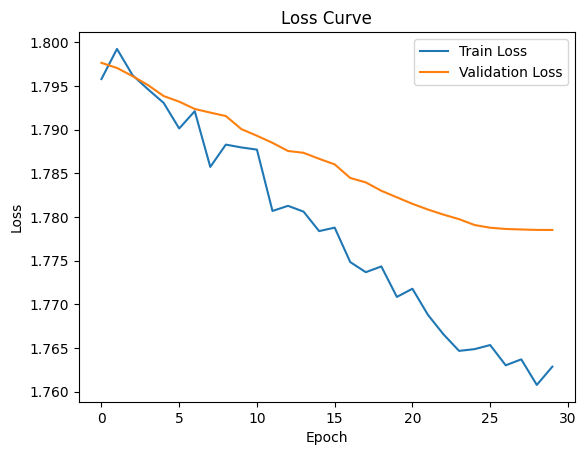

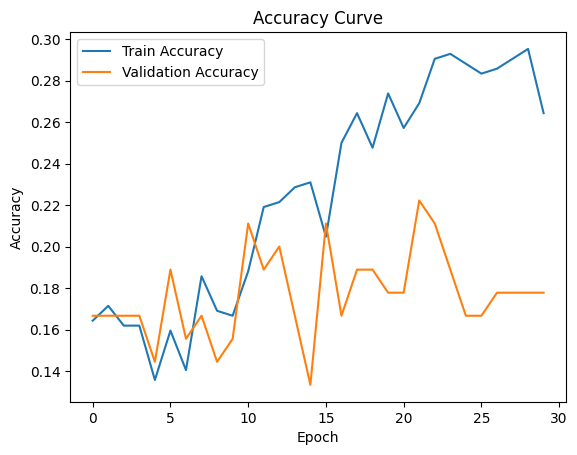

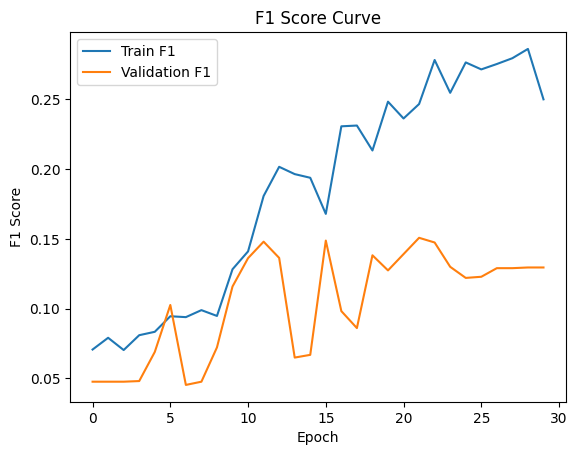

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7958,1.7977,0.1643,0.1667,0.0707,0.0476
1,2,1.7993,1.7971,0.1714,0.1667,0.0791,0.0476
2,3,1.7962,1.7961,0.1619,0.1667,0.0703,0.0476
3,4,1.7946,1.7951,0.1619,0.1667,0.0810,0.0481
4,5,1.7931,1.7939,0.1357,0.1444,0.0834,0.0689
5,6,1.7901,1.7932,0.1595,0.1889,0.0945,0.1026
6,7,1.7921,1.7924,0.1405,0.1556,0.0939,0.0453
7,8,1.7857,1.7920,0.1857,0.1667,0.0989,0.0476
8,9,1.7883,1.7916,0.1690,0.1444,0.0948,0.0722
9,10,1.7880,1.7901,0.1667,0.1556,0.1282,0.1159


In [7]:
num_layers = 1
use_skip_connections = True

experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# 2 layers, no skip, GraphConv

Epoch 1/30
Train Loss: 1.7934 | Validation Loss: 1.7934
Train Acc: 0.1690 | Validation Acc: 0.1667
Train F1: 0.0800 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.7935 | Validation Loss: 1.7933
Train Acc: 0.1619 | Validation Acc: 0.1667
Train F1: 0.0754 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.7932 | Validation Loss: 1.7932
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0774 | Validation F1: 0.0476

Epoch 4/30
Train Loss: 1.7933 | Validation Loss: 1.7931
Train Acc: 0.1619 | Validation Acc: 0.1667
Train F1: 0.0679 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.7932 | Validation Loss: 1.7930
Train Acc: 0.1810 | Validation Acc: 0.1667
Train F1: 0.0821 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.7929 | Validation Loss: 1.7928
Train Acc: 0.1571 | Validation Acc: 0.1667
Train F1: 0.0732 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7931 | Validation Loss: 1.7929
Train Acc: 0.1833 | Validation Acc: 0.1667
Train F1: 0.0918 | Validation F1: 0.0476

Epoch 8/30
Tr

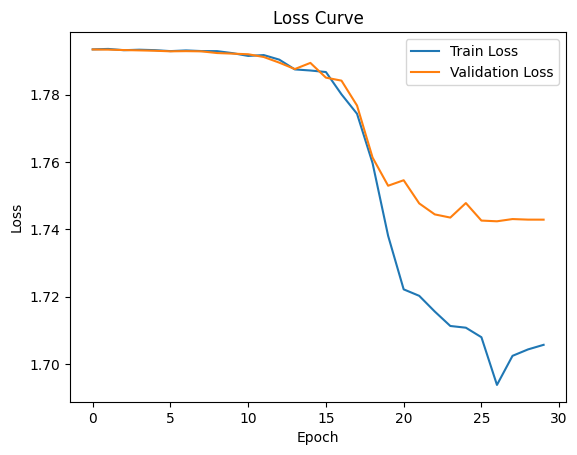

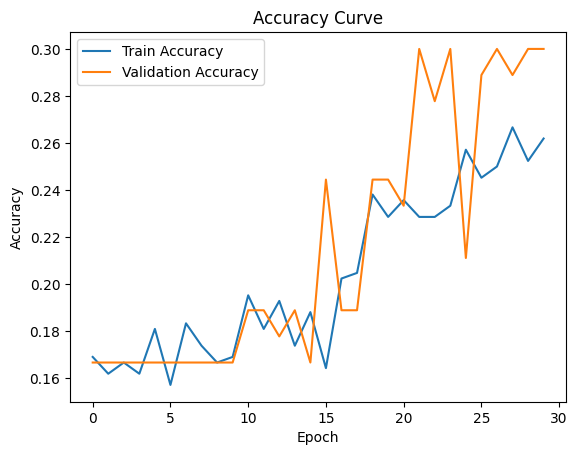

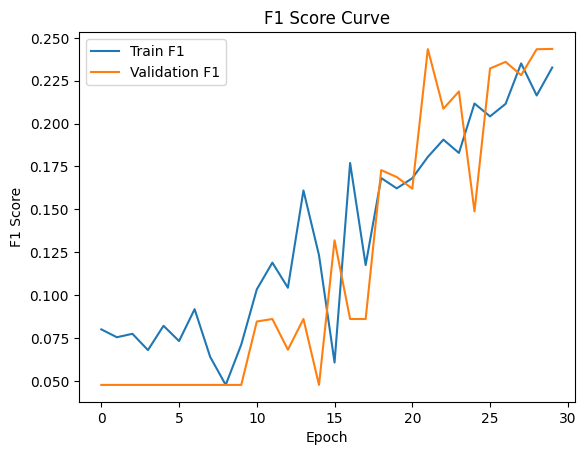

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7934,1.7934,0.1690,0.1667,0.0800,0.0476
1,2,1.7935,1.7933,0.1619,0.1667,0.0754,0.0476
2,3,1.7932,1.7932,0.1667,0.1667,0.0774,0.0476
3,4,1.7933,1.7931,0.1619,0.1667,0.0679,0.0476
4,5,1.7932,1.7930,0.1810,0.1667,0.0821,0.0476
5,6,1.7929,1.7928,0.1571,0.1667,0.0732,0.0476
6,7,1.7931,1.7929,0.1833,0.1667,0.0918,0.0476
7,8,1.7929,1.7928,0.1738,0.1667,0.0640,0.0476
8,9,1.7929,1.7923,0.1667,0.1667,0.0476,0.0476
9,10,1.7923,1.7921,0.1690,0.1667,0.0712,0.0476


In [8]:
num_layers = 2
use_skip_connections = False

experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# 2 layers, skip, GraphConv

Epoch 1/30
Train Loss: 1.8053 | Validation Loss: 1.7994
Train Acc: 0.1619 | Validation Acc: 0.1667
Train F1: 0.0686 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.8043 | Validation Loss: 1.7978
Train Acc: 0.1786 | Validation Acc: 0.1667
Train F1: 0.0786 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.8004 | Validation Loss: 1.7951
Train Acc: 0.1667 | Validation Acc: 0.1889
Train F1: 0.0788 | Validation F1: 0.0861

Epoch 4/30
Train Loss: 1.7962 | Validation Loss: 1.7923
Train Acc: 0.1643 | Validation Acc: 0.1778
Train F1: 0.0844 | Validation F1: 0.0910

Epoch 5/30
Train Loss: 1.7949 | Validation Loss: 1.7904
Train Acc: 0.1762 | Validation Acc: 0.1556
Train F1: 0.1079 | Validation F1: 0.0458

Epoch 6/30
Train Loss: 1.7903 | Validation Loss: 1.7896
Train Acc: 0.1762 | Validation Acc: 0.1778
Train F1: 0.1400 | Validation F1: 0.1017

Epoch 7/30
Train Loss: 1.7907 | Validation Loss: 1.7894
Train Acc: 0.1857 | Validation Acc: 0.1556
Train F1: 0.1407 | Validation F1: 0.0462

Epoch 8/30
Tr

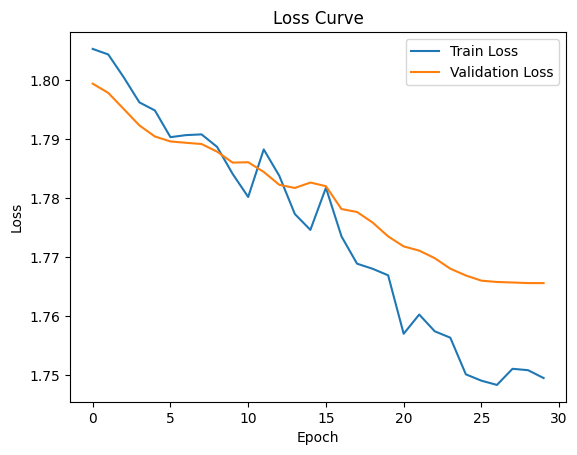

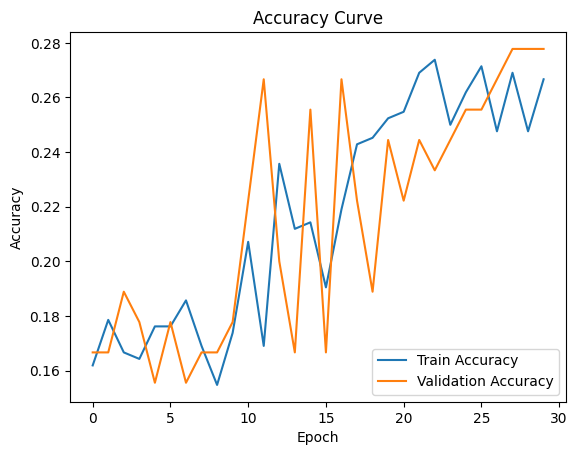

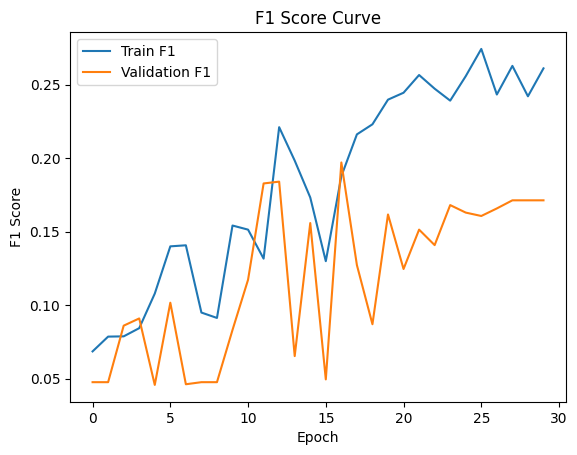

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8053,1.7994,0.1619,0.1667,0.0686,0.0476
1,2,1.8043,1.7978,0.1786,0.1667,0.0786,0.0476
2,3,1.8004,1.7951,0.1667,0.1889,0.0788,0.0861
3,4,1.7962,1.7923,0.1643,0.1778,0.0844,0.0910
4,5,1.7949,1.7904,0.1762,0.1556,0.1079,0.0458
5,6,1.7903,1.7896,0.1762,0.1778,0.1400,0.1017
6,7,1.7907,1.7894,0.1857,0.1556,0.1407,0.0462
7,8,1.7908,1.7892,0.1690,0.1667,0.0950,0.0476
8,9,1.7887,1.7879,0.1548,0.1667,0.0913,0.0476
9,10,1.7841,1.7860,0.1738,0.1778,0.1542,0.0832


In [9]:
num_layers = 2
use_skip_connections = True

experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# 3 layers, no skip, GraphConv

Epoch 1/30
Train Loss: 1.7936 | Validation Loss: 1.7937
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.7940 | Validation Loss: 1.7936
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.7941 | Validation Loss: 1.7935
Train Acc: 0.1643 | Validation Acc: 0.1667
Train F1: 0.0470 | Validation F1: 0.0476

Epoch 4/30
Train Loss: 1.7934 | Validation Loss: 1.7934
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.7936 | Validation Loss: 1.7934
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.7933 | Validation Loss: 1.7931
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7931 | Validation Loss: 1.7930
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0476 | Validation F1: 0.0476

Epoch 8/30
Tr

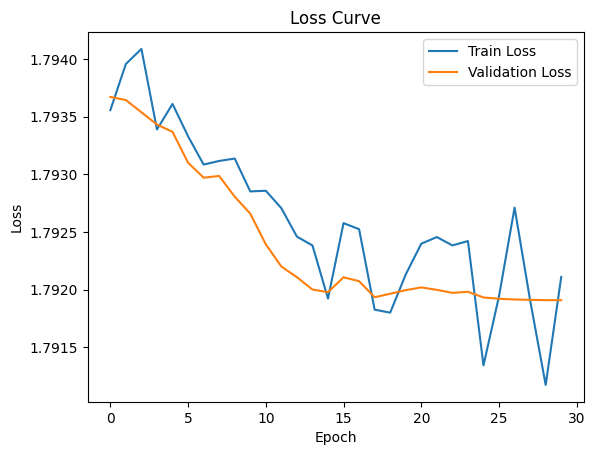

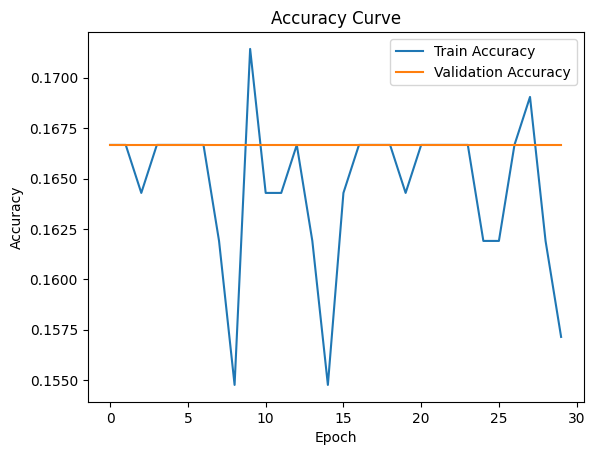

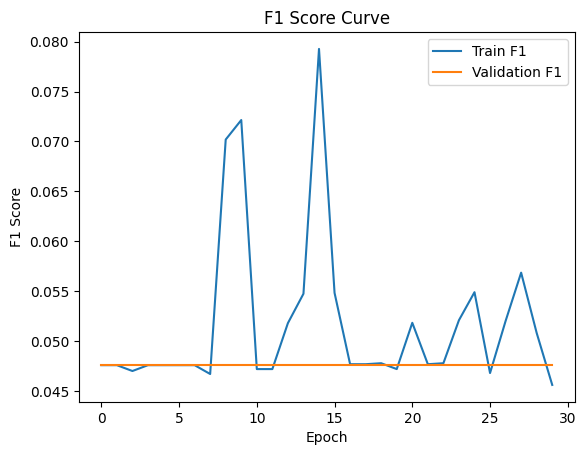

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7936,1.7937,0.1667,0.1667,0.0476,0.0476
1,2,1.7940,1.7936,0.1667,0.1667,0.0476,0.0476
2,3,1.7941,1.7935,0.1643,0.1667,0.0470,0.0476
3,4,1.7934,1.7934,0.1667,0.1667,0.0476,0.0476
4,5,1.7936,1.7934,0.1667,0.1667,0.0476,0.0476
5,6,1.7933,1.7931,0.1667,0.1667,0.0476,0.0476
6,7,1.7931,1.7930,0.1667,0.1667,0.0476,0.0476
7,8,1.7931,1.7930,0.1619,0.1667,0.0467,0.0476
8,9,1.7931,1.7928,0.1548,0.1667,0.0702,0.0476
9,10,1.7929,1.7927,0.1714,0.1667,0.0721,0.0476


In [10]:
num_layers = 3
use_skip_connections = False

experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# 3 layers, skip, GraphConv

Epoch 1/30
Train Loss: 1.8007 | Validation Loss: 1.7970
Train Acc: 0.1786 | Validation Acc: 0.1667
Train F1: 0.0805 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.8011 | Validation Loss: 1.7965
Train Acc: 0.1690 | Validation Acc: 0.1667
Train F1: 0.0734 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.7974 | Validation Loss: 1.7956
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0707 | Validation F1: 0.0476

Epoch 4/30
Train Loss: 1.7969 | Validation Loss: 1.7946
Train Acc: 0.1690 | Validation Acc: 0.1667
Train F1: 0.0844 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.7966 | Validation Loss: 1.7937
Train Acc: 0.1571 | Validation Acc: 0.1556
Train F1: 0.0728 | Validation F1: 0.0741

Epoch 6/30
Train Loss: 1.7930 | Validation Loss: 1.7927
Train Acc: 0.1452 | Validation Acc: 0.1667
Train F1: 0.0909 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7933 | Validation Loss: 1.7923
Train Acc: 0.1738 | Validation Acc: 0.1667
Train F1: 0.1163 | Validation F1: 0.0476

Epoch 8/30
Tr

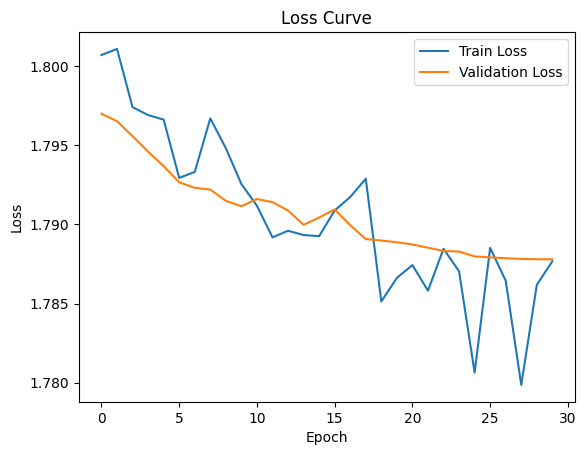

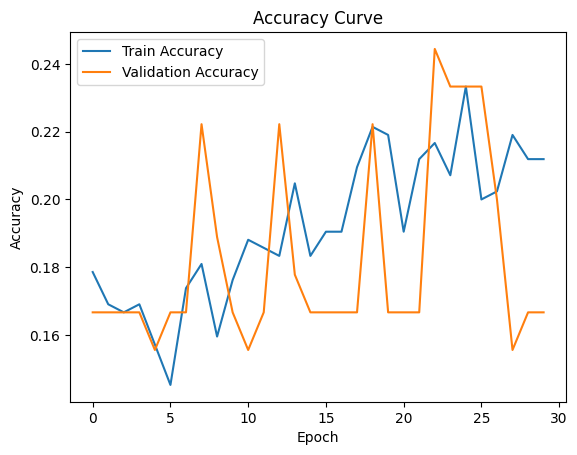

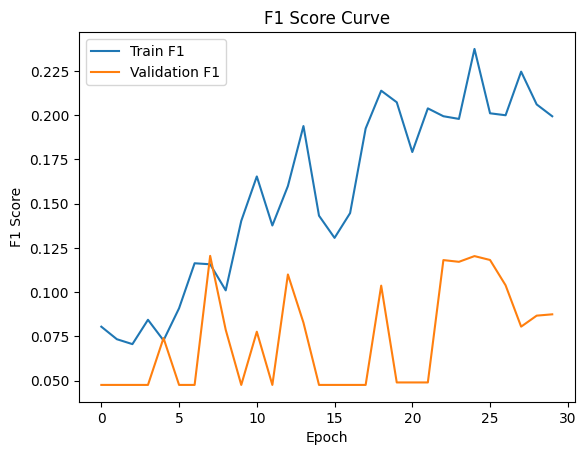

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8007,1.7970,0.1786,0.1667,0.0805,0.0476
1,2,1.8011,1.7965,0.1690,0.1667,0.0734,0.0476
2,3,1.7974,1.7956,0.1667,0.1667,0.0707,0.0476
3,4,1.7969,1.7946,0.1690,0.1667,0.0844,0.0476
4,5,1.7966,1.7937,0.1571,0.1556,0.0728,0.0741
5,6,1.7930,1.7927,0.1452,0.1667,0.0909,0.0476
6,7,1.7933,1.7923,0.1738,0.1667,0.1163,0.0476
7,8,1.7967,1.7922,0.1810,0.2222,0.1158,0.1205
8,9,1.7948,1.7915,0.1595,0.1889,0.1010,0.0788
9,10,1.7926,1.7912,0.1762,0.1667,0.1403,0.0476


In [11]:
num_layers = 3
use_skip_connections = True

experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)